# In search for persistent customer support problems

Author:
* Luis

We want to search for persistent issues in a store customer support. 
We define "persistent issue" when a issue level/count for a certain store is higher by x*std(Moving Average of similar sized stores number of occurencies of a issue), being x a positive integer number (to be determined), for t periods of time.

We start by investigating if stores have different volumes os reviews, what would indicate that some stores are bigger than others (one hypothesis is that larger stores have more clients and therefore a larger number of reviews) and we must account for that when estimating the MA.

Next, we will compare stores issues levels with the relevant moving average for that issue. We hope to identify stores that deviates a lot and use that to inform stakeholders to investigate further.


In [1]:
%cd ..

/home/lois/pojetos/ds4a/notebook


In [2]:
from src.loading import load_dataset
from pprint import pprint

# dataset_path = "dataset/GB_tagged_final_0501"
dataset_path = "dataset/GB_dataset_final_total"
reviewsGB = load_dataset(dataset_path, "id_review", "jl")

print(f"We have a total of {len(reviewsGB)} reviews!")
pprint(reviewsGB[0])

We have a total of 149147 reviews!
{'caption': '',
 'geo_location': {'lat': '-23.4940375', 'long': '-46.4407272'},
 'id_review': 'ChZDSUhNMG9nS0VJQ0FnSUNjalk3WkNREAEaFkEzemp5cVBzOTdVYktVQ1pyempFNWc',
 'n_photo_user': 0,
 'n_review_user': 10,
 'rating': 5.0,
 'relative_date': '3 semanas atrás',
 'retrieval_date': '2020-04-15T02:22:32Z',
 'store': 'magazine-luiza',
 'url_user': 'https://www.google.com/maps/contrib/109471119968482173303?hl=pt-BR',
 'username': 'Elisangela Gomes'}


In [5]:
import pandas as pd
from src.cleaning import format_GB_to_df

dff = pd.DataFrame([format_GB_to_df(row) for row in reviewsGB])
dff['year'] = dff['date_comment'].dt.year
dff['month'] = dff['date_comment'].dt.strftime('%m/%Y')
dff['week'] = dff['date_comment'].dt.week
dff = dff[[col for col in dff.columns if col not in ["products_Home Appliances","products_Eletronics","products_Furniture","products_Accessories","products_Decoration","products_Others"]]]  # remove product columns that are not tagged
dff.head()

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,store,url_user,username,...,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,year,month,week
0,,ChZDSUhNMG9nS0VJQ0FnSUNjalk3WkNREAEaFkEzemp5cV...,0,10,5.0,3 semanas atrás,2020-04-15T02:22:32Z,magazine-luiza,https://www.google.com/maps/contrib/1094711199...,Elisangela Gomes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,13
1,Bom,ChdDSUhNMG9nS0VJQ0FnSUNjdFlPYnlBRRABGhY5OXNsZ3...,0,0,4.0,3 semanas atrás,2020-04-15T02:22:32Z,magazine-luiza,https://www.google.com/maps/contrib/1145288013...,José Givaldo Oliveira,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,13
2,Muito agradável ..,ChdDSUhNMG9nS0VJQ0FnSUNjdGRXeDNBRRABGhZsNGNLTl...,0,0,4.0,3 semanas atrás,2020-04-15T02:22:32Z,magazine-luiza,https://www.google.com/maps/contrib/1170352234...,Fernando Barbosa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,13
3,,ChdDSUhNMG9nS0VJQ0FnSUNjbGNhdjF3RRABGhZZNWVhc3...,0,0,5.0,4 semanas atrás,2020-04-15T02:22:32Z,magazine-luiza,https://www.google.com/maps/contrib/1097484439...,Jonas Leite,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,12
4,,ChZDSUhNMG9nS0VJQ0FnSUNjNWMzN0h3EAEaFlJ1YzRFRT...,0,0,5.0,4 semanas atrás,2020-04-15T02:22:32Z,magazine-luiza,https://www.google.com/maps/contrib/1029138280...,Paulo Roberto,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,03/2020,12


In [6]:
def get_stores_ids(gb_df):
    """
    Get a human readable id for each store
    """
    store_map = dict()
    for store in gb_df.store.unique():
        unique_stores = gb_df.loc[gb_df.store == store].apply(lambda x: f"{x['latitude']}_{x['longitude']}", axis=1).unique()
        store_map.update({geo:f"{store}_{idx}" for idx,geo in enumerate(unique_stores)})
    
    return gb_df.apply(lambda x: store_map[f"{x['latitude']}_{x['longitude']}"], axis=1)

dff["store_id"] = get_stores_ids(dff)
dff.store_id.head()

0    magazine-luiza_0
1    magazine-luiza_0
2    magazine-luiza_0
3    magazine-luiza_0
4    magazine-luiza_0
Name: store_id, dtype: object

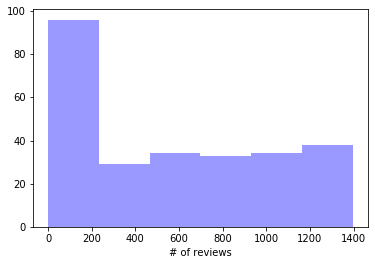

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# f, axes = plt.subplots(1, figsize=(7, 7), sharex=True)
sns.distplot(dff.groupby("store_id").count().id_review, kde=False, color="b", axlabel="# of reviews")

In [13]:
import numpy as np


array([ 200,  400,  600,  800, 1000, 1200])

## Store size variable
We need to compare apples with apples, thus we will create class variables for each of the previous histogram buckets (given that they are somewhat equaly distributed).

Next, we proceed to check what is the percentage of negative reviews for each bucket.

In [16]:
def map_size_class(value):
    if value > 1200:
        return "t6"
    elif value > 1000:
        return "t5"
    elif value > 800:
        return "t4"
    elif value > 600:
        return "t3"
    elif value > 400:
        return "t2"
    elif value > 200:
        return "t1"
    else:
        return "t0"

store_class_map = dff.groupby("store_id").count().id_review.apply(lambda x: map_size_class(x))
store_class_map.head()

store_id
casas-bahia_0     t6
casas-bahia_1     t6
casas-bahia_10    t3
casas-bahia_11    t6
casas-bahia_12    t5
Name: id_review, dtype: object

### Estimating moving averages

In [44]:
issues_columns = [col for col in dff.columns if "issue" in col]
print(issues_columns)

['product_issues_Quality', 'product_issues_Damaged', 'product_issues_Electrical problems', 'product_issues_Missing pieces', 'business_issues_Payment', 'business_issues_Maintenance', 'business_issues_Customer Services', 'business_issues_Delivery', 'business_issues_Online Services', 'product_issues', 'business_issues']


In [42]:
dff.index = dff.date_comment

In [47]:
dff[issues_columns].rolling(2, center=True).mean().head()

,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,product_issues,business_issues
date_comment,,,,,,,,,,,
2020-01-16 05:33:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-17 05:33:21,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2019-12-17 05:33:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-17 05:33:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2019-11-17 05:33:41,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0


In [73]:
agg_df = dff.groupby("date_comment").mean()[issues_columns]

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,store,url_user,username,latitude,longitude,len_comment,relative,date_comment,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,year,month,week,store_id
0,Vende eletros domésticos quebrado. Comprei um...,ChZDSUhNMG9nS0VJQ0FnSURNNXBERUFREAEaFjZwVEFadG...,0,39,2.0,3 meses atrás,2020-04-15T05:33:14Z,magazine-luiza,https://www.google.com/maps/contrib/1078399353...,Mercia Oliveira,-23.5975251,-46.6025457,74,90,2020-01-16 05:33:14,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2020,01/2020,3,magazine-luiza_0
1,Som muito alto,ChdDSUhNMG9nS0VJQ0FnSUNNdjhMWHF3RRABGhZ2bHdkUX...,0,0,1.0,4 meses atrás,2020-04-15T05:33:21Z,magazine-luiza,https://www.google.com/maps/contrib/1096235498...,Wendy Castiello,-23.5975251,-46.6025457,14,120,2019-12-17 05:33:21,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2019,12/2019,51,magazine-luiza_0
2,Péssimo atendimento e não tem telefone para at...,ChZDSUhNMG9nS0VJQ0FnSUNNdDVidE5nEAEaFmE3R1pMTG...,0,14,1.0,4 meses atrás,2020-04-15T05:33:21Z,magazine-luiza,https://www.google.com/maps/contrib/1136403911...,Gilberto Alves,-23.5975251,-46.6025457,147,120,2019-12-17 05:33:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,2019,12/2019,51,magazine-luiza_0
3,Péssima.. Pessoas descompromissadas...me impe...,ChdDSUhNMG9nS0VJQ0FnSUQwdE5QTzVRRRABGhZVOThjbX...,0,1,1.0,5 meses atrás,2020-04-15T05:33:41Z,magazine-luiza,https://www.google.com/maps/contrib/1074240831...,Anderson Freire Carniel,-23.5975251,-46.6025457,432,150,2019-11-17 05:33:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,2019,11/2019,46,magazine-luiza_0
4,Bom atendimento.,ChdDSUhNMG9nS0VJQ0FnSUQwa083dHdnRRABGhYwY000cj...,0,0,1.0,5 meses atrás,2020-04-15T05:33:41Z,magazine-luiza,https://www.google.com/maps/contrib/1176573277...,Helena Stauber,-23.5975251,-46.6025457,16,150,2019-11-17 05:33:41,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,3.0,2019,11/2019,46,magazine-luiza_0


In [61]:
store_df = dff.groupby(["store_id", "date_comment"]).count()
store_df.head()

caption  id_review  n_photo_user  n_review_user  rating  relative_date  ...  products  product_issues  business_issues  year  month  week
store_id      date_comment                                                                                 ...                                                              
casas-bahia_0 2017-04-15 14:44:41        1          1             1              1       1              1  ...         0               0                1     1      1     1
              2017-04-15 14:44:51        2          2             2              2       2              2  ...         0               0                2     2      2     2
              2017-04-15 14:45:02        1          1             1              1       1              1  ...         0               0                1     1      1     1
              2017-04-15 14:45:12        1          1             1              1       1              1  ...         0               0                1     1      1     1
              2017-04-15 14:45:23        1          1             1              1       1              1  ...         0               0                1     1      1     1

[5 rows x 30 columns]

In [72]:
test = store_df.loc['casas-bahia_0',:].resample('M').sum()[issues_columns]

test.mask(test == 0).interpolate()

,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,product_issues,business_issues
date_comment,,,,,,,,,,,
2017-04-30,NaN,NaN,NaN,NaN,3.000000,1.000000,5.000000,2.000000,NaN,NaN,6.000000
2017-05-31,NaN,NaN,NaN,NaN,3.083333,1.416667,5.333333,2.083333,NaN,NaN,6.333333
2017-06-30,NaN,NaN,NaN,NaN,3.166667,1.833333,5.666667,2.166667,NaN,NaN,6.666667
2017-07-31,NaN,NaN,NaN,NaN,3.250000,2.250000,6.000000,2.250000,NaN,NaN,7.000000
2017-08-31,NaN,NaN,NaN,NaN,3.333333,2.666667,6.333333,2.333333,NaN,NaN,7.333333
2017-09-30,NaN,NaN,NaN,NaN,3.416667,3.083333,6.666667,2.416667,NaN,NaN,7.666667
2017-10-31,NaN,NaN,NaN,NaN,3.500000,3.500000,7.000000,2.500000,NaN,NaN,8.000000
2017-11-30,NaN,NaN,NaN,NaN,3.583333,3.916667,7.333333,2.583333,NaN,NaN,8.333333
2017-12-31,NaN,NaN,NaN,NaN,3.666667,4.333333,7.666667,2.666667,NaN,NaN,8.666667


In [66]:
store_df.loc['casas-bahia_0',:].rolling(7).sum()

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,store,url_user,username,latitude,longitude,len_comment,relative,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,year,month,week
date_comment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-04-15 14:44:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-15 14:44:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-15 14:45:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-15 14:45:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-15 14:45:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-15 14:41:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-15 14:41:48,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,7.0,3.0,0.0,0.0,1.0,8.0,9.0,9.0,9.0
2018-04-15 14:41:58,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,0.0,1.0,1.0,0.0,0.0,3.0,4.0,7.0,3.0,0.0,0.0,1.0,8.0,9.0,9.0,9.0
2018-04-15 14:42:27,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,2.0,2.0,0.0,0.0,4.0,5.0,8.0,2.0,0.0,0.0,2.0,8.0,10.0,10.0,10.0


In [56]:
dff.resample('M').sum()

,n_photo_user,n_review_user,rating,len_comment,relative,others,product_issues_Quality,product_issues_Damaged,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,year,week
date_comment,,,,,,,,,,,,,,,,,,,,
2013-04-30,0,28,12.0,2308,15330,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,0.0,0.0,0.0,8.0,12078,96
2013-05-31,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2013-06-30,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2013-07-31,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2013-08-31,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,0,1910,598.0,57149,66900,0.0,141.0,141.0,0.0,0.0,101.0,130.0,238.0,113.0,1.0,0.0,282.0,583.0,900474,20560
2019-12-31,0,4136,921.0,87297,84120,0.0,235.0,235.0,0.0,0.0,148.0,188.0,364.0,196.0,1.0,0.0,470.0,897.0,1415319,35550
2020-01-31,0,3783,1004.0,106050,67860,0.0,217.0,217.0,0.0,0.0,153.0,218.0,418.0,221.0,0.0,0.0,434.0,1010.0,1523080,2262
